In [19]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np 
import requests
from pprint import pprint
from scipy.optimize import curve_fit
import random
import datetime
import seaborn as sns
from tqdm import tqdm 
from scipy.stats import linregress

# Import the OpenWeatherMap API key
from api_keys import weather_api_key
from api_keys import geoapify_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")


In [23]:
# Store filepath in a variable and read
file_1 = os.path.join("Resources/us_counties_covid19_daily.csv")
file_2 = os.path.join("Resources/county_info_city.csv")

C19_df = pd.read_csv(file_1, encoding="ISO-8859-1")
C19_Ccounty_df =pd.read_csv(file_2, encoding="ISO-8859-1")

C19_df.head(10)


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
5,2020-01-25,Orange,California,6059.0,1,0.0
6,2020-01-25,Cook,Illinois,17031.0,1,0.0
7,2020-01-25,Snohomish,Washington,53061.0,1,0.0
8,2020-01-26,Maricopa,Arizona,4013.0,1,0.0
9,2020-01-26,Los Angeles,California,6037.0,1,0.0


In [24]:
covid_df = C19_df
covid_df['combined'] = covid_df['county'] + "," + covid_df['state']
covid_df.head(5)

,date,county,state,fips,cases,deaths,combined
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"
3,2020-01-24,Cook,Illinois,17031.0,1,0.0,"Cook,Illinois"
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"


In [30]:
# Select rows in my date range
# Make a start and end date
Beg_date = '2020-06-01'

# Make an end date
end_date = '2020-08-31'

# Select DataFrame rows between two dates
mask = (covid_df['date'] > Beg_date) & (C19_df['date'] <= end_date)
summer_covid_df = covid_df.loc[mask]

summer_covid_df.head()

,date,county,state,fips,cases,deaths,combined
199923,2020-06-02,Autauga,Alabama,1001.0,240,5.0,"Autauga,Alabama"
199924,2020-06-02,Baldwin,Alabama,1003.0,308,9.0,"Baldwin,Alabama"
199925,2020-06-02,Barbour,Alabama,1005.0,176,1.0,"Barbour,Alabama"
199926,2020-06-02,Bibb,Alabama,1007.0,79,1.0,"Bibb,Alabama"
199927,2020-06-02,Blount,Alabama,1009.0,65,1.0,"Blount,Alabama"


In [32]:
# Sort by date and reset index
summer_covid_df=  summer_covid_df.sort_values('date')
summer_covid_df = summer_covid_df.reset_index(drop=True)

summer_covid_df.head()

,date,county,state,fips,cases,deaths,combined
0,2020-06-02,Autauga,Alabama,1001.0,240,5.0,"Autauga,Alabama"
1,2020-06-02,St. Charles,Missouri,29183.0,799,61.0,"St. Charles,Missouri"
2,2020-06-02,Baldwin,Alabama,1003.0,308,9.0,"Baldwin,Alabama"
3,2020-06-02,Barbour,Alabama,1005.0,176,1.0,"Barbour,Alabama"
4,2020-06-02,Bibb,Alabama,1007.0,79,1.0,"Bibb,Alabama"


In [33]:
# Combine Seat and State to get a city, state format
cols = ['Seat', 'State']
county_df['combined'] = county_df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)

# Show new dataframe
county_df.head()

,State,County FIPS Code,County or Equivalent,Seat,combined
0,Alabama,1001,Autauga County,Prattville,"Prattville, Alabama"
1,Alabama,1003,Baldwin County,Bay Minette,"Bay Minette, Alabama"
2,Alabama,1005,Barbour County,Clayton,"Clayton, Alabama"
3,Alabama,1007,Bibb County,Centreville,"Centreville, Alabama"
4,Alabama,1009,Blount County,Oneonta,"Oneonta, Alabama"


In [34]:
# Organize the data by grouping by counties and calculating the total cases
county_cases_df = summer_covid_df.groupby(['county']).agg({'cases': 'sum'})

county_cases_df.head(10)

,cases
county,
Abbeville,19184
Acadia,149844
Accomack,96320
Ada,494759
Adair,49039
Adams,655195
Addison,6420
Adjuntas,6350
Aguada,7804


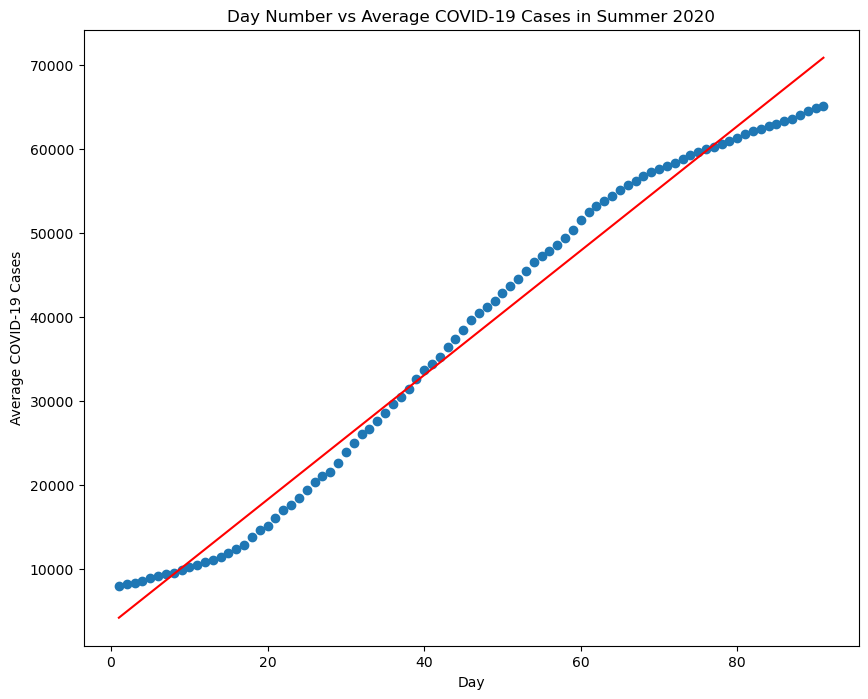

In [62]:

#Create scatter plot of day number vs. average COVID-19 cases for summer
day_number = [i+1 for i in range(summer_covid_df['date'].nunique())]
avg_cases = summer_covid_df.groupby(['date']).agg({'cases': 'mean'})
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(day_number, avg_cases) 
plt.xlabel('Day')
plt.ylabel('Average COVID-19 Cases')
plt.title('Day Number vs Average COVID-19 Cases in Summer 2020')

# Calculate the line of best fit using linear regression
x = np.array(day_number)
y = np.array(avg_cases['cases'])
line = np.polyfit(x, y, 1)
plt.plot(x, line[0]*x + line[1], color='red')


# Calculate the r-squared value
r_squared = np.corrcoef(x, y)[0, 1] ** 2

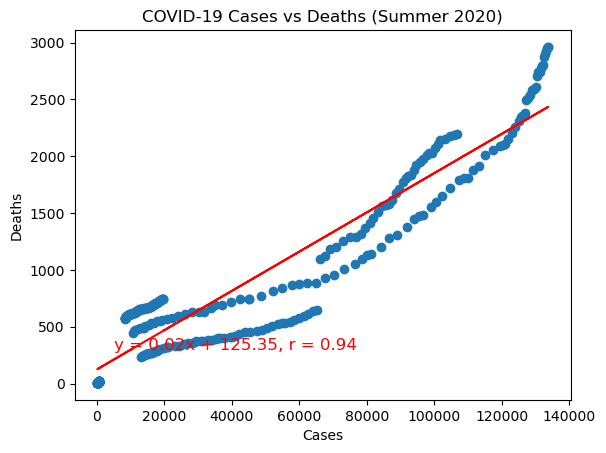

In [63]:
# Build scatter plot for avg cases vs death in 2020
slope, intercept, r_value, p_value, std_err = linregress(summer_covid_df['cases'], summer_covid_df['deaths'])
line = slope * summer_covid_df['cases'] + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}, r = {r_value:.2f}"
plt.scatter(summer_covid_df['cases'], summer_covid_df['deaths'])
plt.plot(summer_covid_df['cases'], line, color='red')
plt.annotate(line_eq, (5000, 300), fontsize=12, color='red')
plt.xlabel('Cases')
plt.ylabel('Deaths')
plt.title('COVID-19 Cases vs Deaths (Summer 2020)')
plt.savefig("summer_outputs/summer_cases_vs_deaths.png")
plt.show()

In [50]:
#three random counties 

selected_counties = ['Harris', 'Maricopa', 'King'] 

summer_covid_df = summer_covid_df[summer_covid_df['county'].isin(selected_counties)]
summer_covid_df.head()


,date,county,state,fips,cases,deaths,combined
95,2020-06-02,Maricopa,Arizona,4013.0,10536,448.0,"Maricopa,Arizona"
446,2020-06-02,Harris,Georgia,13145.0,102,6.0,"Harris,Georgia"
2576,2020-06-02,Harris,Texas,48201.0,13027,236.0,"Harris,Texas"
2904,2020-06-02,King,Washington,53033.0,8237,572.0,"King,Washington"
3239,2020-06-03,Maricopa,Arizona,4013.0,11068,466.0,"Maricopa,Arizona"


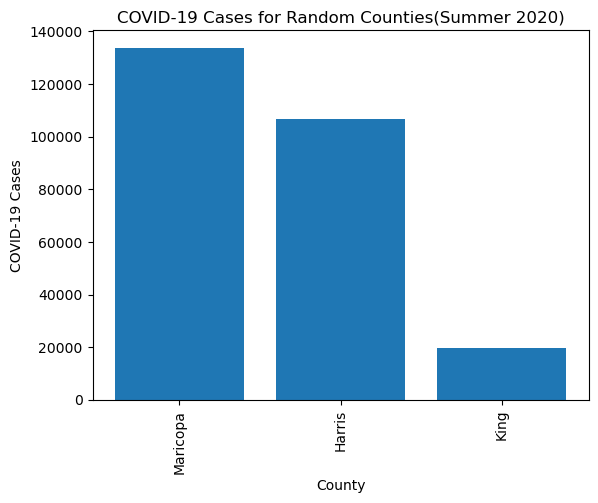

In [55]:
#Create bar graph of top COVID-19 cases in the selected Random Cities for summer
random_covid_df = summer_covid_df.groupby('county')['cases'].sum().reset_index().sort_values('cases', ascending=False).head(10)
plt.bar(summer_covid_df['county'], summer_covid_df['cases'])
plt.xticks(rotation=90)
plt.xlabel('County')
plt.ylabel('COVID-19 Cases')
plt.title('COVID-19 Cases for Random Counties(Summer 2020)')
plt.savefig("summer_outputs/cases_random_counties.png")
plt.show()


In [212]:
def get_weather_data(county, date):
    geo_url = "https://api.geoapify.com/v1/geocode/search"
    weather_url = "https://api.openweathermap.org/data/3.0/onecall/timemachine?"
    units = "metric"

    # Specify the county and date for which you want weather data
    query_params = {
        'key': api_key,
        'q': county,
        'dt': date
    }

    # Make the API request
    response = requests.get(base_url, params=query_params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()

        # Extract the required weather data
        temp_c = data['forecast']['forecastday'][0]['day']['avgtemp_c']
        wind_kph = data['forecast']['forecastday'][0]['day']['maxwind_kph']
        humidity = data['forecast']['forecastday'][0]['day']['avghumidity']
        
        weather_data = {
            'temp_c': temp_c,
            'wind_kph': wind_kph,
            'humidity': humidity
        }
        
        return weather_data
    else:
        print('Error occurred while fetching weather data.')


In [61]:

weather_data_list = []

for county in tqdm(selected_counties, desc='Processing Counties'):
    #county_data = summer_covid_df[summer_covid_df['county'] == county]

        
        # Call the get_weather_data() function to retrieve weather data
weather_data = get_weather_data(county, date)
        
temperature = weather_data['temp_c']
wind_speed = weather_data['wind_kph']
humidity = weather_data['humidity']
        
weather_data_list.append((county, date, temperature, wind_speed, humidity))

weather_df = pd.DataFrame(weather_data_list, columns=['County', 'Date', 'Temperature', 'Wind Speed', 'Humidity'])
summer_covid_df = summer_covid_df.merge(weather_df, left_on=['county'], right_on=['County', 'Date'])
summer_covid_df = summer_covid_df.drop(['County', 'Date'], axis=1)



In [ ]:
final_df = summer_covid_df

###Relationship between temperature (C) in summer and daily COVID cases in each of our 3 counties in 2020


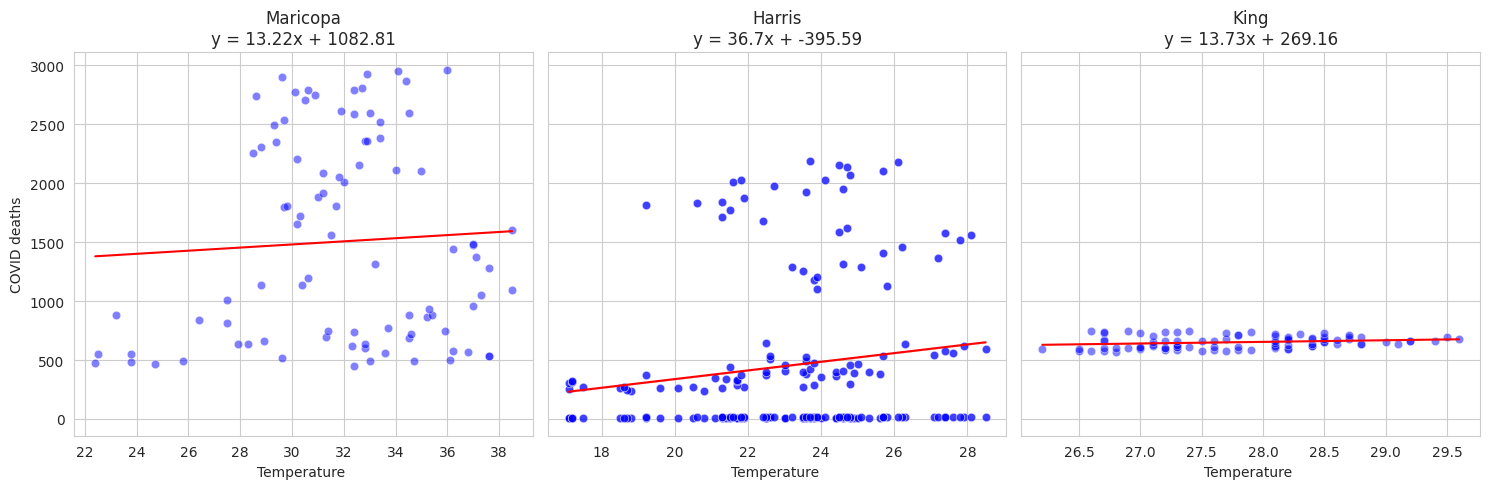

In [221]:
counties = final_df['county'].unique()[:3]  

fig, axes = plt.subplots(nrows=1, ncols=len(counties), figsize=(15, 5), sharey=True)

for i, county in enumerate(counties):
    county_data = final_df[final_df['county'] == county]
    
    # Perform regression analysis
    humidity = county_data['Temperature']
    cases = county_data['deaths']
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(humidity, cases)
    fit = [(slope * x) + intercept for x in humidity]
    equation = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    
    # Plot the relationship
    ax = axes[i]
    sns.scatterplot(data=county_data, x='Temperature', y='deaths', ax=ax, color='b', alpha=0.5)
    sns.lineplot(x=humidity, y=fit, ax=ax, color='r')
    ax.set_xlabel('Temperature ')
    ax.set_ylabel('COVID deaths')
    ax.set_title(county + '\n' + equation)
    
plt.tight_layout()
plt.savefig("summer_outputs/deaths_vs_temp.png")
plt.show()


###Relationship between temperature (C) in summer and daily COVID deaths in each of our 3 counties in 2020

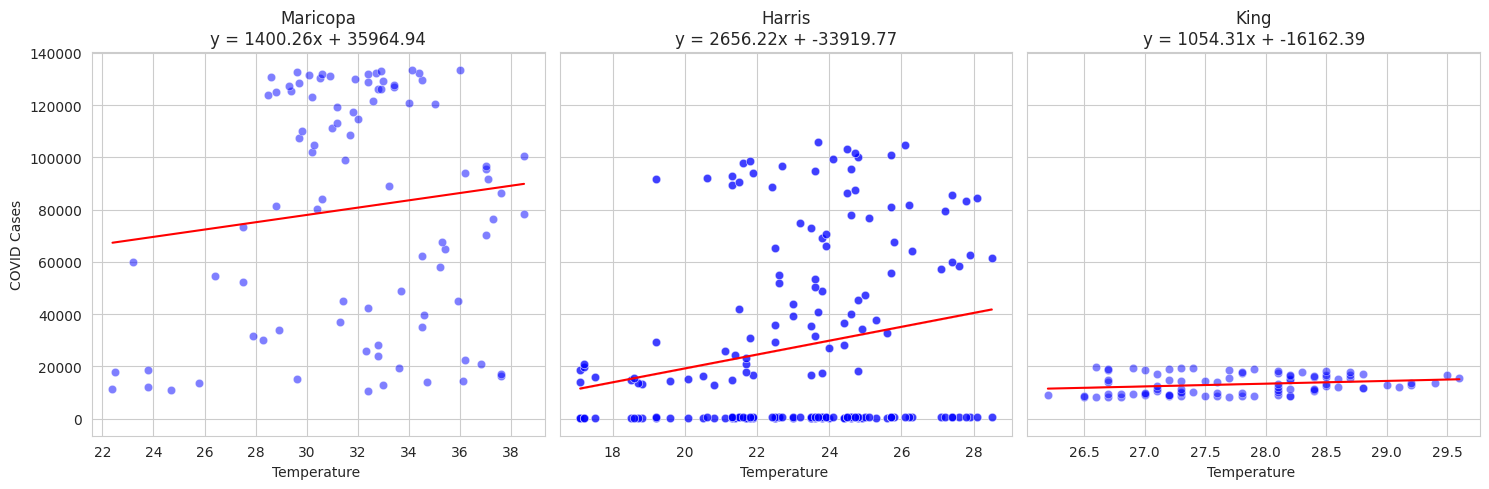

In [222]:
counties = final_df['county'].unique()[:3]  

fig, axes = plt.subplots(nrows=1, ncols=len(counties), figsize=(15, 5), sharey=True)

# Perform regression analysis and plot for each county
for i, county in enumerate(counties):
    county_data = final_df[final_df['county'] == county]
    
    # Perform regression analysis
    humidity = county_data['Temperature']
    cases = county_data['cases']
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(humidity, cases)
    fit = [(slope * x) + intercept for x in humidity]
    equation = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    
    # Plot the relationship
    ax = axes[i]
    sns.scatterplot(data=county_data, x='Temperature', y='cases', ax=ax, color='b', alpha=0.5)
    sns.lineplot(x=humidity, y=fit, ax=ax, color='r')
    ax.set_xlabel('Temperature ')
    ax.set_ylabel('COVID Cases')
    ax.set_title(county + '\n' + equation)
    
plt.tight_layout()
plt.savefig("summer_outputs/cases_vs_temp.png")
plt.show()


###Relationship between humidity (%) in summer and daily COVID cases in each of our 3 counties in 2020

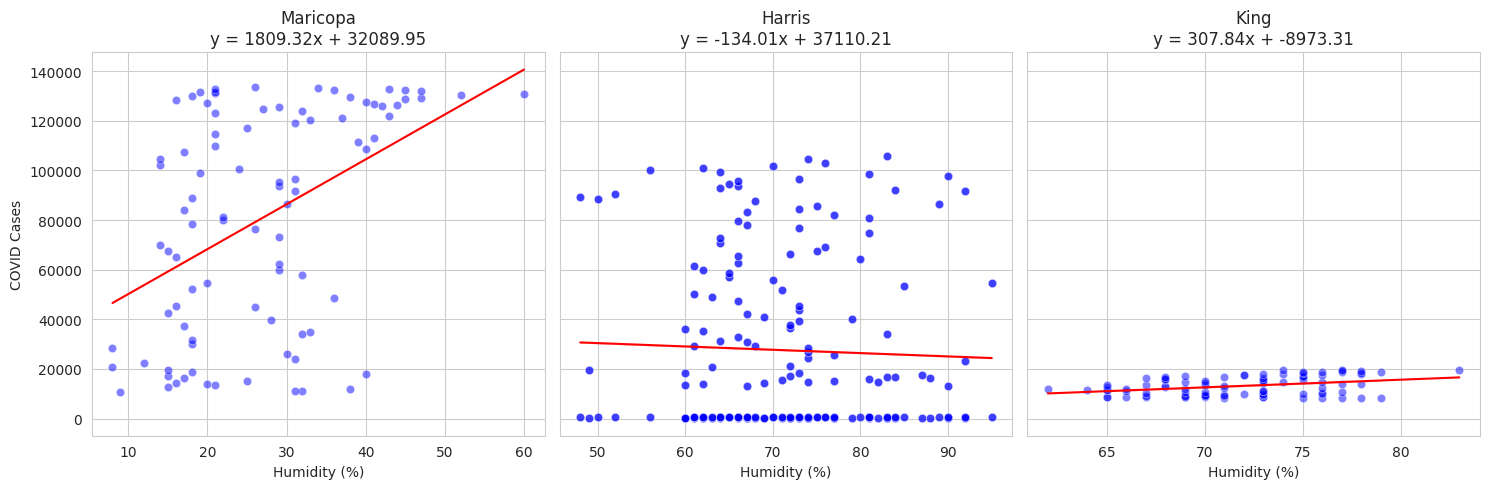

In [223]:
counties = final_df['county'].unique()[:3] 

fig, axes = plt.subplots(nrows=1, ncols=len(counties), figsize=(15, 5), sharey=True)

# Perform regression analysis and plot for each county
for i, county in enumerate(counties):
    county_data = final_df[final_df['county'] == county]
    
    # Perform regression analysis
    humidity = county_data['Humidity']
    cases = county_data['cases']
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(humidity, cases)
    fit = [(slope * x) + intercept for x in humidity]
    equation = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    
    # Plot the relationship
    ax = axes[i]
    sns.scatterplot(data=county_data, x='Humidity', y='cases', ax=ax, color='b', alpha=0.5)
    sns.lineplot(x=humidity, y=fit, ax=ax, color='r')
    ax.set_xlabel('Humidity (%)')
    ax.set_ylabel('COVID Cases')
    ax.set_title(county + '\n' + equation)
    
plt.tight_layout()
plt.savefig("summer_outputs/cases_vs_humidity.png")
plt.show()


###Relationship between windspeed in summer and daily COVID cases in each of our 3 counties in 2020

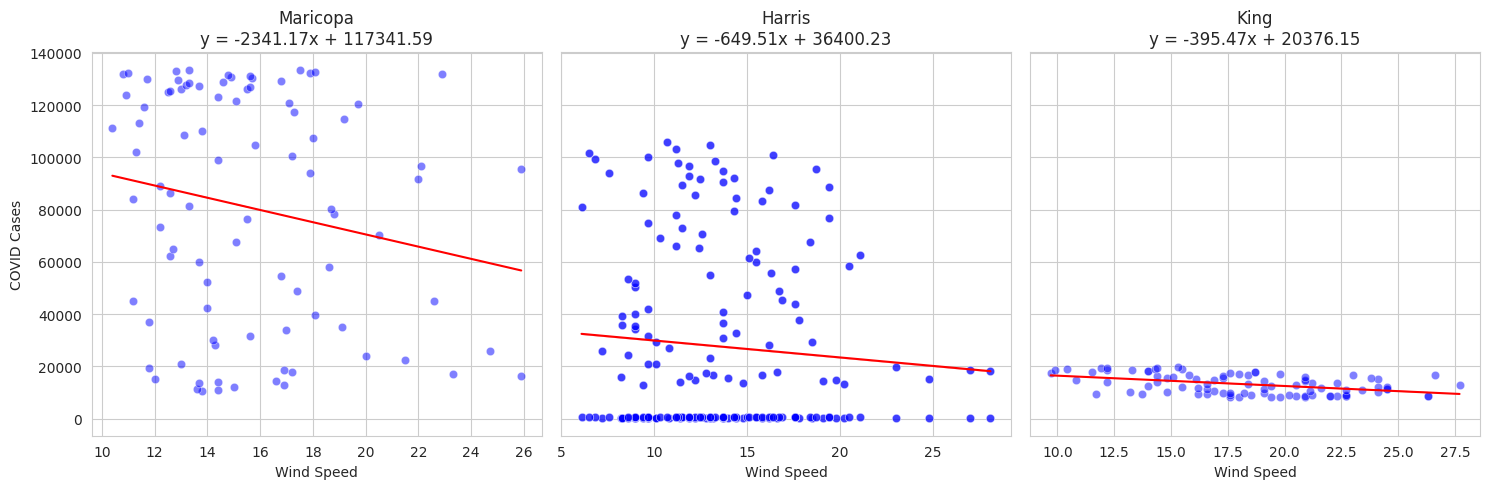

In [224]:
counties = final_df['county'].unique()[:3] 

fig, axes = plt.subplots(nrows=1, ncols=len(counties), figsize=(15, 5), sharey=True)

# Perform regression analysis and plot for each county
for i, county in enumerate(counties):
    county_data = final_df[final_df['county'] == county]
    
    # Perform regression analysis
    humidity = county_data['Wind Speed']
    cases = county_data['cases']
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(humidity, cases)
    fit = [(slope * x) + intercept for x in humidity]
    equation = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    
    # Plot the relationship
    ax = axes[i]
    sns.scatterplot(data=county_data, x='Wind Speed', y='cases', ax=ax, color='b', alpha=0.5)
    sns.lineplot(x=humidity, y=fit, ax=ax, color='r')
    ax.set_xlabel('Wind Speed')
    ax.set_ylabel('COVID Cases')
    ax.set_title(county + '\n' + equation)
    
plt.tight_layout()
plt.savefig("summer_outputs/cases_vs_windspeed.png")
plt.show()
